In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [146]:
os.chdir('C:/Users/aamal/Desktop/Springboard/Springboard_DataScience/Capstone-3-Solar/Data')

df = pd.read_csv('solar_cleaned.csv')

In [3]:
df.head()

,DATE_TIME,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,HOUR,DAY_OF_WEEK,MONTH,Cumulative_Yield,Normalized_Yield,Inverter_Efficiency,Plant_Efficiency
0,2020-05-15 00:00:00,1,25.184316,22.857507,0.0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,0,4,5,6259559.0,0.0,0.0,0.052321
1,2020-05-15 00:00:00,1,25.184316,22.857507,0.0,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,0,4,5,12443204.0,0.0,0.0,0.052321
2,2020-05-15 00:00:00,1,25.184316,22.857507,0.0,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,0,4,5,19430963.0,0.0,0.0,0.052321
3,2020-05-15 00:00:00,1,25.184316,22.857507,0.0,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,0,4,5,27033923.0,0.0,0.0,0.052321
4,2020-05-15 00:00:00,1,25.184316,22.857507,0.0,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,0,4,5,34192887.0,0.0,0.0,0.052321


In [4]:
df.dtypes

DATE_TIME               object
PLANT_ID                 int64
AMBIENT_TEMPERATURE    float64
MODULE_TEMPERATURE     float64
IRRADIATION            float64
SOURCE_KEY              object
DC_POWER               float64
AC_POWER               float64
DAILY_YIELD            float64
TOTAL_YIELD            float64
HOUR                     int64
DAY_OF_WEEK              int64
MONTH                    int64
Cumulative_Yield       float64
Normalized_Yield       float64
Inverter_Efficiency    float64
Plant_Efficiency       float64
dtype: object

In [148]:
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [150]:
datetimes_full = pd.Series(pd.date_range(df.DATE_TIME.min(), 
                                         df.DATE_TIME.max(), 
                                         freq='15min'), 
                           name='DATE_TIME')
datetimes_full

0      2020-05-15 00:00:00
1      2020-05-15 00:15:00
2      2020-05-15 00:30:00
3      2020-05-15 00:45:00
4      2020-05-15 01:00:00
               ...        
3259   2020-06-17 22:45:00
3260   2020-06-17 23:00:00
3261   2020-06-17 23:15:00
3262   2020-06-17 23:30:00
3263   2020-06-17 23:45:00
Name: DATE_TIME, Length: 3264, dtype: datetime64[ns]

In [152]:
df['HOUR'] = df.DATE_TIME.dt.hour
df['DAY'] = df.DATE_TIME.dt.dayofyear
df['DAY_WEEK'] = df.DATE_TIME.dt.dayofweek
df['MINUTES_15'] = df.DATE_TIME.dt.time

#This maps the 15 minute intervals over the course of the day to ints 1-96. 
df['MINUTES_15'] = df.MINUTES_15.map({df.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
#Change day of year to day of data
df['DAY'] = df.DAY.map({df.DAY.unique()[i-1]:i for i in range(1, 35)})

In [154]:
df.columns

Index(['DATE_TIME', 'PLANT_ID', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD',
       'TOTAL_YIELD', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'Cumulative_Yield',
       'Normalized_Yield', 'Inverter_Efficiency', 'Plant_Efficiency', 'DAY',
       'DAY_WEEK', 'MINUTES_15'],
      dtype='object')

In [156]:
scaler = MinMaxScaler()
numerical_cols = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 
                   'DC_POWER', 'AC_POWER', 'Inverter_Efficiency', 'Cumulative_Yield', 
                    'Normalized_Yield', 'Plant_Efficiency']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [158]:
df['Lag_1_DC_POWER'] = df['DC_POWER'].shift(1)  # Previous 15 minutes
df['Lag_4_DC_POWER'] = df['DC_POWER'].shift(4)  # 1 hour ago

df['Lag_1_AC_POWER'] = df['AC_POWER'].shift(1)
df['Lag_4_AC_POWER'] = df['AC_POWER'].shift(4)

In [160]:
day = 96
#shifting to day ahead and dropping nulls cause by the shift
target = df.groupby('DATE_TIME').sum(numeric_only=True).AC_POWER.shift(-day)
target = target.dropna()

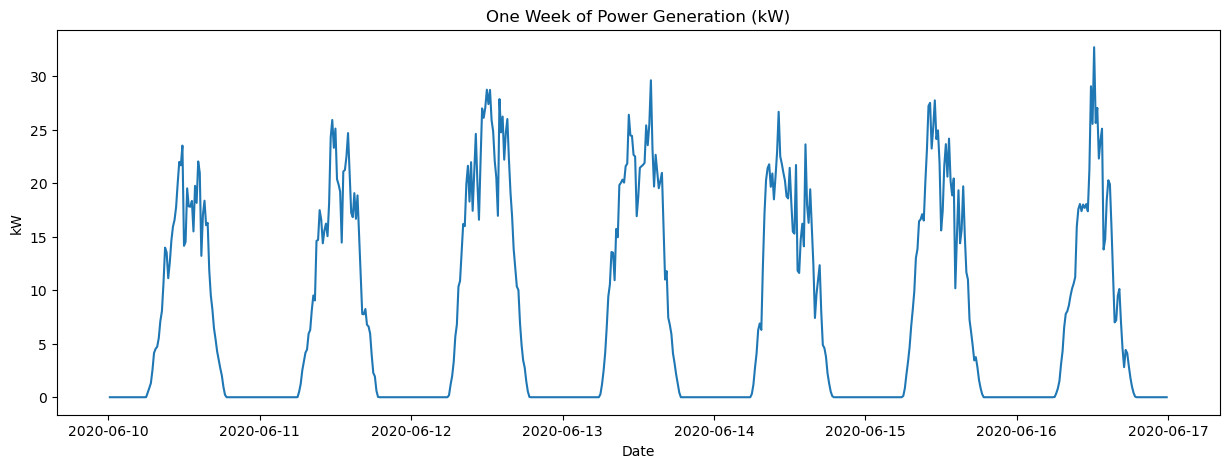

In [162]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(target[target.index > '2020-06-10'])
plt.title('One Week of Power Generation (kW)')
plt.xlabel('Date')
plt.ylabel('kW');

In [164]:
generation = ['AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
weather = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
all_features = ['AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 
                'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
#Aggregating data across inverters. We will sum the generation data and take the mean of the weather data. 
#Also, adding back basic datetime features
df_agg = pd.concat([df.groupby('DATE_TIME')[generation].sum(numeric_only=True), 
                    df.groupby('DATE_TIME').mean(numeric_only=True)[weather]], axis=1)

df_agg['HOUR'] = df_agg.index.hour
df_agg['DAY'] = df_agg.index.dayofyear
df_agg['DAY_WEEK'] = df_agg.index.dayofweek
df_agg['MINUTES_15'] = df_agg.index.time

#15 minute intervals over the course of the day to ints 1-96. 
df_agg['MINUTES_15'] = df_agg.MINUTES_15.map({df_agg.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
#Change day of year to day of data
df_agg['DAY'] = df_agg.DAY.map({df_agg.DAY.unique()[i-1]:i for i in range(1, 35)})



#Copy for deep learning model
df_agg_dl = df_agg.copy()


In [166]:
day = 96
#last 3 days for testing and the rest for training
target_test = target[-3*day:]
target_train = target[:-3*day]
#moving target back a day
baseline_preds = target.shift(day)[-3*day:]
baseline_score = np.round(mean_squared_error(target_test, 
                                             baseline_preds, 
                                             squared=False), 
                          4)
print('baseline_score: ', baseline_score)

baseline_score:  3.6484


C:\DataScience\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


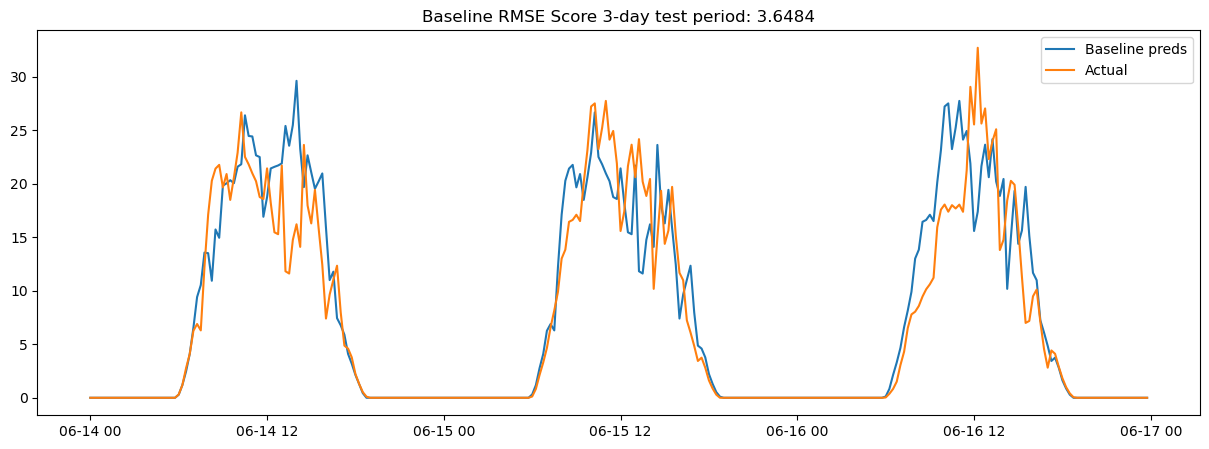

In [168]:
fig, ax = plt.subplots(figsize=(15,5))
#plt.plot(X[X.index > '2020-06-10'].index, y_pred[X.index > '2020-06-10'], alpha=0.5)
plt.plot(baseline_preds, label='baseline')
plt.plot(target_test);
plt.title(f'Baseline RMSE Score 3-day test period: {baseline_score}')
plt.legend(['Baseline preds', 'Actual']);

In [170]:
from sklearn.model_selection import TimeSeriesSplit
day = 96
tscv = TimeSeriesSplit(test_size=day, n_splits=29)
cv_indices = []
#since all our inverter splits share the same index we'll just choose df_agg
for train_indices, test_indices in tscv.split(df_agg.iloc[:-day*4]):
    cv_indices.append((train_indices, test_indices))

In [198]:
df_agg_train = df_agg.iloc[:-day*4]
df_agg_test = df_agg.iloc[-day*4:-day]

In [200]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=1)
param_grid = {
    'n_estimators': [50, 100, 200],     # Number of boosting rounds
    'max_depth': [3, 5, 7],            # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2], # Shrinkage rate
    'subsample': [0.8, 1.0],           # Subsampling fraction
}
gs_model = GridSearchCV(xgb, 
                  param_grid=param_grid, 
                  cv=cv_indices, 
                  verbose=10, 
                  scoring='neg_root_mean_squared_error')
gs_model.fit(df_agg_train, target_train)

Fitting 29 folds for each of 54 candidates, totalling 1566 fits
[CV 1/29; 1/54] START learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8
[CV 1/29; 1/54] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=-7.264 total time=   0.0s
[CV 2/29; 1/54] START learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8
[CV 2/29; 1/54] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=-6.232 total time=   0.0s
[CV 3/29; 1/54] START learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8
[CV 3/29; 1/54] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=-6.528 total time=   0.0s
[CV 4/29; 1/54] START learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8
[CV 4/29; 1/54] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=-5.528 total time=   0.0s
[CV 5/29; 1/54] START learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8
[CV 5/29; 1/54] END learning_rate=

GridSearchCV(cv=[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93]),
                  array([ 94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 10...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [212]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],     # Number of boosting rounds
    'max_depth': [3, 5, 7],            # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2], # Shrinkage rate
    'subsample': [0.8, 1.0],           # Subsampling fraction
}
gs_model = GridSearchCV(xgb, 
                  param_grid=param_grid, 
                  cv=cv_indices, 
                  verbose=10, 
                  scoring='neg_root_mean_squared_error')
gs_model.fit(df_agg_train, target_train)

Fitting 29 folds for each of 54 candidates, totalling 1566 fits
[CV 1/29; 1/54] START learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8
[CV 1/29; 1/54] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=-7.275 total time=   0.0s
[CV 2/29; 1/54] START learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8
[CV 2/29; 1/54] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=-6.252 total time=   0.0s
[CV 3/29; 1/54] START learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8
[CV 3/29; 1/54] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=-6.514 total time=   0.0s
[CV 4/29; 1/54] START learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8
[CV 4/29; 1/54] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=-5.544 total time=   0.0s
[CV 5/29; 1/54] START learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8
[CV 5/29; 1/54] END learning_rate=

GridSearchCV(cv=[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93]),
                  array([ 94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 10...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [204]:
xgb_preds = gs_model.best_estimator_.predict(df_agg_test)

# RMSE for XGBoost
xgb_rmse = np.sqrt(mean_squared_error(target_test, xgb_preds))
print(f"XGBoost RMSE: {xgb_rmse}")


XGBoost RMSE: 3.1759446917706025


In [206]:
from sklearn.metrics import mean_absolute_error, r2_score

xgb_mae = mean_absolute_error(target_test, xgb_preds)
xgb_r2 = r2_score(target_test, xgb_preds)
print(f"XGBoost MAE: {xgb_mae}")
print(f"XGBoost R2 Score: {xgb_r2}")

XGBoost MAE: 1.8081577325397147
XGBoost R2 Score: 0.8745031689130969


In [208]:
best_xgb = gs.best_estimator_
pd.DataFrame(best_xgb.feature_importances_.T, 
             index=list(best_xgb.feature_names_in_), 
             columns=['Feature_Importance']).sort_values('Feature_Importance', ascending=False)

,Feature_Importance
IRRADIATION,0.851143
HOUR,0.025770
AC_POWER,0.024917
DAY_WEEK,0.018653
MINUTES_15,0.016196
DAY,0.015815
DAILY_YIELD,0.012295
TOTAL_YIELD,0.011443
MODULE_TEMPERATURE,0.010394
AMBIENT_TEMPERATURE,0.007513


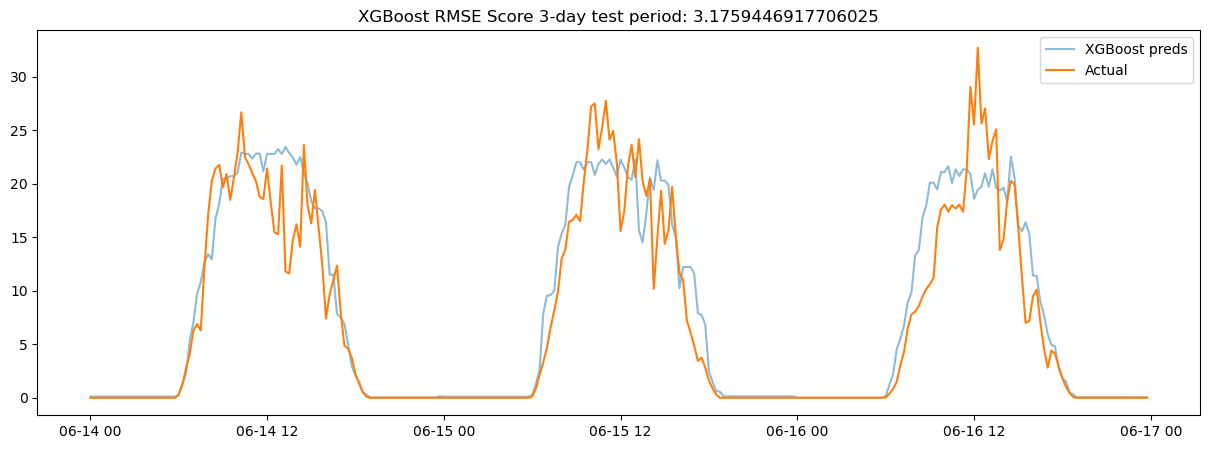

In [210]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(target_test.index, xgb_preds, label='XGBoost preds', alpha=0.5)
plt.plot(target_test, label='Actual')
plt.title(f'XGBoost RMSE Score 3-day test period: {xgb_rmse}')
plt.legend(['XGBoost preds', 'Actual'])
plt.show()

In [302]:
inputs_agg_train_stack = tf.stack(inputs_agg_trains)
print(inputs_agg_train_stack.shape)  # Should now work without errors

InvalidArgumentError: {{function_node __wrapped__Pack_N_22_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [382,11] != values[1].shape = [384,11] [Op:Pack]

In [300]:
### df_agg full data including weather
inputs_agg_trains = []
labels_agg_trains = []
for i in range(3, len(cv_indices)-4):
    input_agg_train = (df_agg.iloc[cv_indices[i][0]] - df_agg.iloc[cv_indices[i][0]].mean()) \
                        / df_agg.iloc[cv_indices[i][0]].std()
    label_agg_train = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) \
                        / target.iloc[cv_indices[i][1]].std()
    label_agg_train = pd.DataFrame(label_agg_train, columns=['AC_POWER'])
    inputs_agg_trains.append(input_agg_train)
    labels_agg_trains.append(label_agg_train)
    
inputs_agg_train_stack = tf.stack(inputs_agg_trains)
labels_agg_train_stack = tf.stack(labels_agg_trains)

inputs_agg_vals = []
labels_agg_vals = []
for i in range(len(cv_indices)-4 , len(cv_indices)):
    input_agg_val = (df_agg.iloc[cv_indices[i][0]] - df_agg.iloc[cv_indices[i][0]].mean()) \
                     / df_agg.iloc[cv_indices[i][0]].std()
    label_agg_val = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) \
                     / target.iloc[cv_indices[i][1]].std()
    label_agg_val = pd.DataFrame(label_sep_val, columns=['AC_POWER'])
    inputs_agg_vals.append(input_agg_val)
    labels_agg_vals.append(label_agg_val)
    
inputs_agg_val_stack = tf.stack(inputs_agg_vals)
labels_agg_val_stack = tf.stack(labels_agg_vals)
    
val = (inputs_agg_val_stack, labels_agg_val_stack)
    

InvalidArgumentError: {{function_node __wrapped__Pack_N_22_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [382,11] != values[1].shape = [384,11] [Op:Pack]

In [194]:
# Ensure at least lookback + 1 rows in the testing set
test_size = lookback + 96 * 3  # Ensure enough rows for 3 days of predictions
train_dl = df_agg_dl.iloc[:-test_size]
test_dl = df_agg_dl.iloc[-test_size:]

# Separate features and target
X_train_dl = train_dl.drop(columns=['AC_POWER'])
y_train_dl = train_dl['AC_POWER']
X_test_dl = test_dl.drop(columns=['AC_POWER'])
y_test_dl = test_dl['AC_POWER']

# Verify shapes
print(f"Training Features: {X_train_dl.shape}, Training Target: {y_train_dl.shape}")
print(f"Testing Features: {X_test_dl.shape}, Testing Target: {y_test_dl.shape}")

Training Features: (2590, 10), Training Target: (2590,)
Testing Features: (672, 10), Testing Target: (672,)


In [196]:
def create_sequences(features, target, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features.iloc[i:i+lookback].values)
        y.append(target.iloc[i+lookback])
    return np.array(X), np.array(y)

lookback = 96 * 4  # Use data from the last 4 days (15-min intervals)
X_train_seq, y_train_seq = create_sequences(X_train_dl, y_train_dl, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_dl, y_test_dl, lookback)

# Verify shapes
print(f"Train Sequences: {X_train_seq.shape}, Train Targets: {y_train_seq.shape}")
print(f"Test Sequences: {X_test_seq.shape}, Test Targets: {y_test_seq.shape}")

Train Sequences: (2206, 384, 10), Train Targets: (2206,)
Test Sequences: (288, 384, 10), Test Targets: (288,)


In [240]:
import tensorflow as tf
#Define LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(96),  # Predict 96 timesteps
    tf.keras.layers.Reshape([96, 1])
])

MAX_EPOCHS = 50  

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # Stop after 20 epochs of no improvement
    mode='min',
    restore_best_weights=True
)

#Compile
lstm_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

#Train
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=MAX_EPOCHS,
    batch_size=32,  # Keep batch size consistent
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - loss: 160.7756 - root_mean_squared_error: 12.6743 - val_loss: 86.7732 - val_root_mean_squared_error: 9.3152
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step - loss: 119.6225 - root_mean_squared_error: 10.9344 - val_loss: 80.5742 - val_root_mean_squared_error: 8.9763
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - loss: 112.7350 - root_mean_squared_error: 10.6145 - val_loss: 81.2690 - val_root_mean_squared_error: 9.0149
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 258ms/step - loss: 109.5639 - root_mean_squared_error: 10.4668 - val_loss: 81.5582 - val_root_mean_squared_error: 9.0310
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 258ms/step - loss: 107.3569 - root_mean_squared_error: 10.3604 - val_loss: 81.9178 - val_root_mean_squared_error: 9.0508
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - loss: 106.3155 - root_mean_squared_error: 10.3029 - val_loss: 81.9080 - val_root_mean_squared_error: 9.0503
Epoch 7/50
69/69 ━━━━━

In [242]:
y_pred_dl = lstm_model.predict(X_test_seq)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


In [260]:
y_train_mean = y_train_seq.mean()
y_train_std = y_train_seq.std()

# Print values to verify
print(f"Mean: {y_train_mean}, Std: {y_train_std}")

Mean: 8.362465603806312, Std: 10.393992816629417


In [262]:
# Example: Denormalize using mean and std from training data
y_pred_dl_denorm = y_pred_dl * y_train_std + y_train_mean

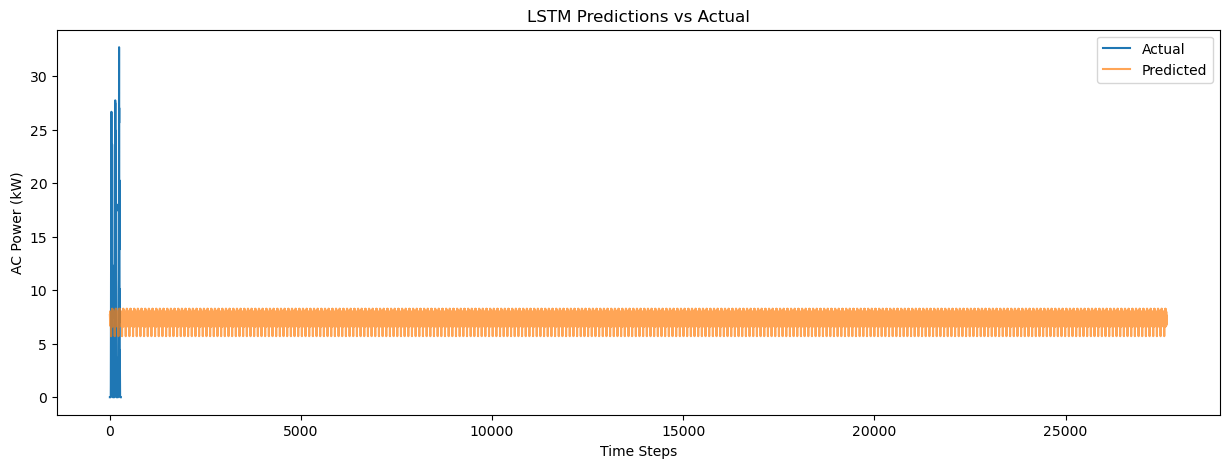

In [264]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.figure(figsize=(15, 5))
plt.plot(y_test_seq.flatten(), label='Actual')
plt.plot(y_pred_dl.flatten(), label='Predicted', alpha=0.7)
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('AC Power (kW)')
plt.legend()
plt.show()

In [ ]:
#To compare to XGBoost Model, the predictions need to be extracting from our model and undo normalization

In [236]:
#Splitting and organizing the test labels 
day_1_labels = target.iloc[-day*3:-day*2]
day_2_labels = target.iloc[-day*2:-day*1]
day_3_labels = target.iloc[-day:]
test_labels = [day_1_labels, day_2_labels, day_3_labels]
test_labels_stack = tf.stack(test_labels)

#Normalizing Test Inputs
day_1_inputs = (df_agg.iloc[-day*7:-day*3] - df_agg.iloc[-day*7:-day*3].mean()) \
                / df_agg.iloc[-day*7:-day*3].std()
day_2_inputs = (df_agg.iloc[-day*6:-day*2] - df_agg.iloc[-day*6:-day*2].mean()) \
                / df_agg.iloc[-day*6:-day*2].std()
day_3_inputs = (df_agg.iloc[-day*5:-day] - df_agg.iloc[-day*5:-day].mean()) \
                / df_agg.iloc[-day*5:-day].std()

test_inputs = [day_1_inputs, day_2_inputs, day_3_inputs]
test_inputs_stack = tf.stack(test_inputs)


#Model predictions
target_norm_preds = lstm_model.predict(test_inputs_stack)

#Denormalizing predictions
labels_preds_day_1 = target_norm_preds[0] * df_agg.iloc[-day*7:-day*3].AC_POWER.std() \
                     + df_agg.iloc[-day*7:-day*3].AC_POWER.mean()
labels_preds_day_2 = target_norm_preds[1] * df_agg.iloc[-day*6:-day*2].AC_POWER.std() \
                     + df_gg.iloc[-day*6:-day*2].AC_POWER.mean()
labels_preds_day_3 = target_norm_preds[2] * df_agg.iloc[-day*5:-day].AC_POWER.std() \
                     + df_agg.iloc[-day*5:-day].AC_POWER.mean()

#Compute Errors
day_1_error = mean_squared_error(test_labels_stack[0], 
                                 labels_preds_day_1, 
                                 squared=False)
day_2_error = mean_squared_error(test_labels_stack[1], 
                                 labels_preds_day_2, 
                                 squared=False)
day_3_error = mean_squared_error(test_labels_stack[2], 
                                 labels_preds_day_3, 
                                 squared=False)
lstm_rsme_score_test_set = np.round((day_1_error + day_2_error + day_3_error) / 3, 4)


#Combine Predictions for Visualization
labels_preds = np.concatenate([labels_preds_day_1, labels_preds_day_2, labels_preds_day_3], axis=None)
test_labels = np.concatenate([test_labels_stack[0], test_labels_stack[1], test_labels_stack[2]], axis=None)


lstm_best = {'best_score':lstm_rsme_score_test_set}

#Visualizing results
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(target.iloc[-3*day:].index, labels_preds)
plt.plot(target.iloc[-3*day:].index, test_labels)
plt.figtext(.13, .85, s=f'RMSE Score test set: {lstm_rsme_score_test_set}')
plt.figtext(.13, .82, s=f'Baseline Score: {baseline_score}')
plt.title('LSTM test set predictions vs actual: Seperated Inverters')
plt.legend(['predicted', 'actual'])
plt.ylabel('AC Power (kW)')
plt.xlabel('Day')

C:\DataScience\Lib\site-packages\tensorflow\python\framework\constant_op.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ops.EagerTensor(value, ctx.device_name, dtype)


InvalidArgumentError: Graph execution error:

Detected at node sequential_4_1/lstm_6_1/while/body/_1/sequential_4_1/lstm_6_1/while/lstm_cell_1/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [3,11], In[1]: [10,256]
	 [[{{node sequential_4_1/lstm_6_1/while/body/_1/sequential_4_1/lstm_6_1/while/lstm_cell_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_50251]

In [ ]:
lstm_preds = lstm_model.predict(X_test).flatten()

# Evaluate RMSE for LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_preds))
print(f"LSTM RMSE: {lstm_rmse}")